## Non-Negative Matrix Factorization (NMF)

*Non-negative matrix factorization* is another unsupervised learning algorithm that aims to extract useful features. It works similarly to PCA and can also be used for dimensionality reduction. As in PCA, we are trying to write each data point as a weighted sum of some components. 

But whereas in PCA we wanted components that were orthogonal and that explained as much variance of the data as possible, in NMF, we want the components and the coefficients to be non-negative; that is, we want both the components and the coefficients to be greater than or equal to zero. Consequently, this method can only be applied to data where each feature is non-negative, as a non-negative sum of non-negative components cannot become negative.

The process of decomposing data into a non-negative weighted sum is particularly helpful for data that is created as the addition (or overlay) of several independent sources, such as an audio track of multiple people speaking, or music with many instruments. In these situations, NMF can identify the original components that make up the combined data. Overall, NMF leads to more interpretable components than PCA, as negative components and coefficients can lead to hard-to-interpret cancellation effects. 

The eigenfaces, for example, contain both positive and negative parts, and as we mentioned in the description of PCA, the sign is actually arbitrary. Before we apply NMF to the face dataset, let’s briefly revisit the synthetic data.

### Applying NMF To Synthetic Data

In contrast to when using PCA, we need to ensure that our data is positive for NMF to be able to operate on the data. This means where the data lies relative to the origin (0, 0) actually matters for NMF. Therefore, you can think of the non-negative components that are extracted as directions from (0, 0) toward the data.

The following example shows the results of NMF on the two-dimensional toy data.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

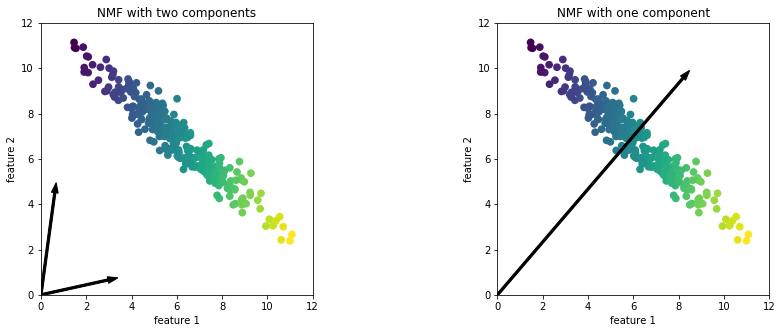

In [3]:
mglearn.plots.plot_nmf_illustration()

For NMF with two components, as shown on the left, it is clear that all points in the data can be written as a positive combination of the two components. If there are enough components to perfectly reconstruct the data (as many components as there are features), the algorithm will choose directions that point toward the extremes of the data.

If we only use a single component, NMF creates a component that points toward the mean, as pointing there best explains the data. You can see that in contrast with PCA, reducing the number of components not only removes some directions, but creates an entirely different set of components! Components in NMF are also not ordered in any specific way, so there is no “first non-negative component”: all components play an equal part.

NMF uses a random initialization, which might lead to different results depending on the random seed. In relatively simple cases such as the synthetic data with two components, where all the data can be explained perfectly, the randomness has little effect (though it might change the order or scale of the components). In more complex situations, there might be more drastic changes.